In [2]:
import torch
import torchvision
import torch.optim as optim
import os
import matplotlib.image as mpimg
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [4]:
train_path = f"/kaggle/input/dl-2025-competition-1/data/train" 
test_path = f"/kaggle/input/dl-2025-competition-1/data/test"

### 1 БЛОК: Анализ данных

In [4]:
class_names = os.listdir(train_path)
num_classes = len(class_names)

print(f"Количество классов: {num_classes}")
print(f"Названия классов: {class_names}")

Количество классов: 100
Названия классов: ['7', '47', '17', '81', '19', '22', '2', '35', '92', '50', '23', '87', '10', '5', '61', '36', '20', '45', '60', '27', '64', '41', '89', '39', '32', '98', '25', '42', '52', '75', '8', '38', '12', '94', '55', '49', '0', '31', '62', '53', '70', '34', '18', '79', '85', '88', '65', '67', '78', '28', '66', '56', '72', '16', '13', '99', '26', '74', '15', '3', '90', '69', '77', '86', '95', '43', '91', '71', '1', '58', '59', '97', '30', '14', '76', '84', '4', '83', '82', '57', '9', '96', '46', '21', '44', '40', '80', '6', '11', '68', '63', '37', '51', '33', '54', '48', '29', '24', '73', '93']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


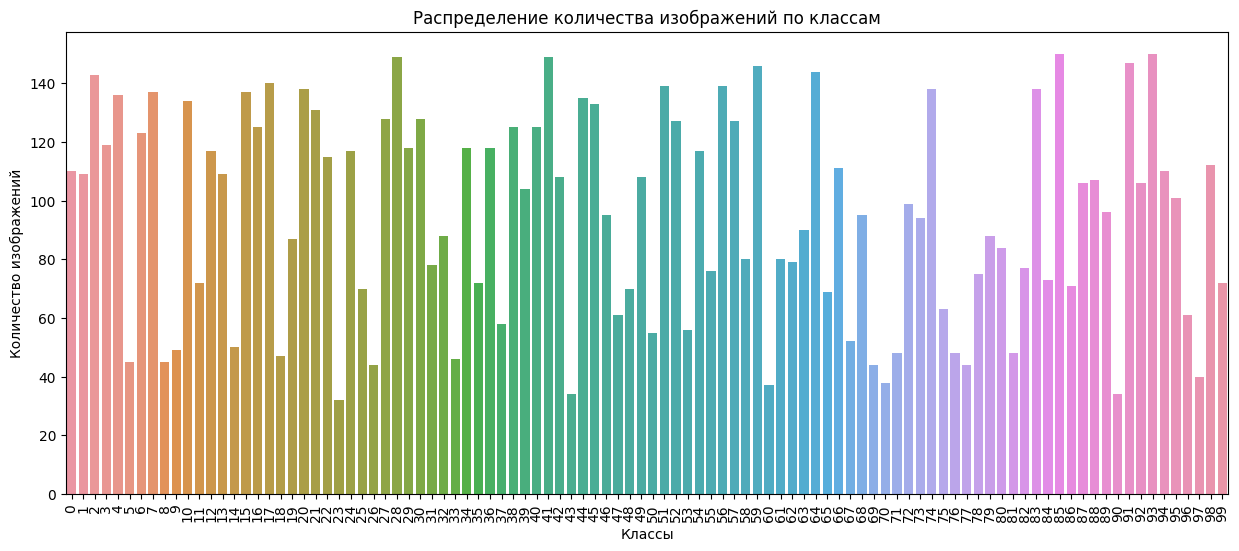

In [5]:
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))


sorted_class_names = sorted(class_names, key=lambda x: int(x))  # Преобразуем в int для сортировки
sorted_class_counts = [class_counts[class_name] for class_name in sorted_class_names]


plt.figure(figsize=(15, 6))
sns.barplot(x=sorted_class_names, y=sorted_class_counts)
plt.xticks(rotation=90)
plt.title('Распределение количества изображений по классам')
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.show()

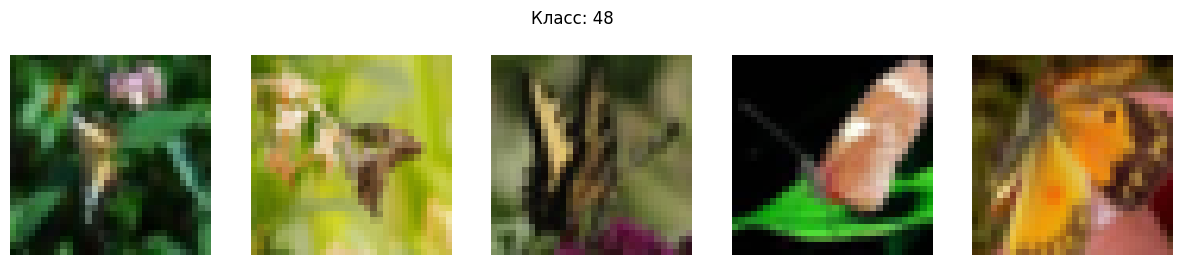

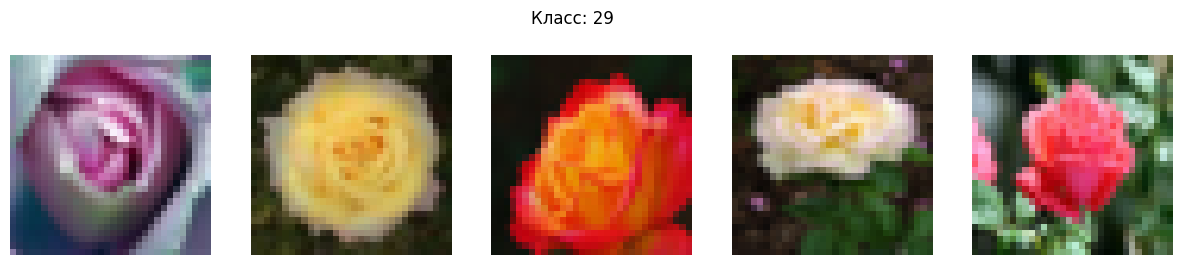

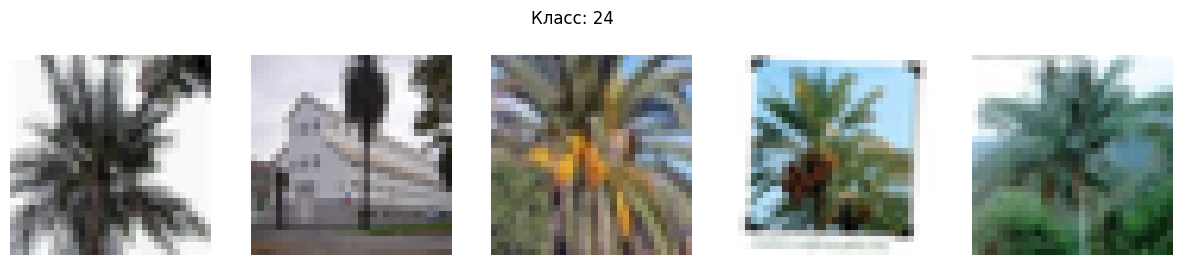

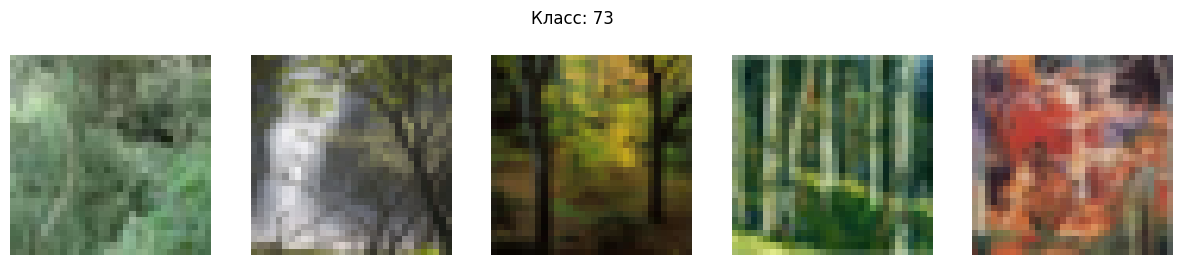

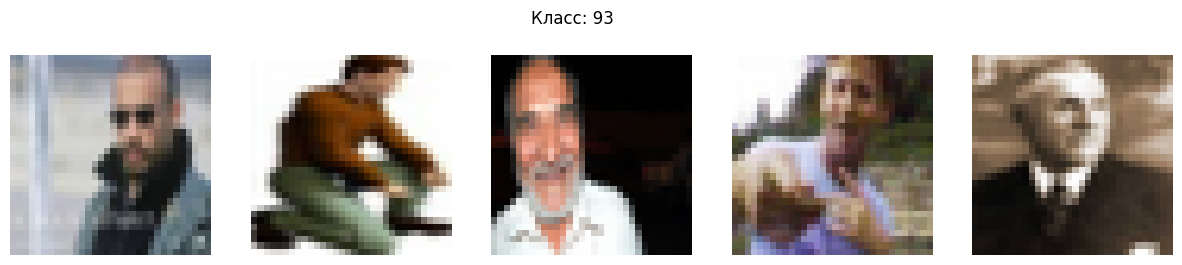

In [6]:
def plot_sample_images(class_name, num_samples=5):
    class_dir = os.path.join(train_path, class_name)
    image_files = os.listdir(class_dir)[:num_samples]
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Класс: {class_name}")
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_dir, image_file)
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


for class_name in class_names[-5:]:
    plot_sample_images(class_name)

In [7]:
test_files = os.listdir(test_path)
print(f"Количество тестовых изображений: {len(test_files)}")

first_test_img = Image.open(os.path.join(test_path, test_files[0]))
print(f"Размер тестового изображения: {first_test_img.size}")

Количество тестовых изображений: 3878
Размер тестового изображения: (32, 32)


### БЛОК 2: Аугментационные пайплайны

In [8]:
#pip install albumentations torchvision

In [9]:
simple_transform = A.Compose([ #Простенькая аугментация
    A.OneOf([
    A.HorizontalFlip(p=1.0),
    A.VerticalFlip(p=1.0),
    ], p=1.0)
])

In [10]:
advanced_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),          # Случайный поворот на 90°
    A.ShiftScaleRotate(                # Сдвиг, масштаб, поворот
        shift_limit=0.1,               # Сдвиг до 10% от размера изображения
        scale_limit=0.2,               # Масштабирование ±20%
        rotate_limit=30,               # Поворот ±30°
        p=0.7
    ),
    A.RandomBrightnessContrast(        # Изменение яркости и контраста
        brightness_limit=0.2,          # ±20% яркости
        contrast_limit=0.2,            # ±20% контраста
        p=0.5
    ),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Размытие Гаусса
    A.CoarseDropout(                   # Случайное удаление областей
        max_holes=8,                   # До 8 "дырок"
        max_height=8,                  # Макс. высота дырки — 8px
        max_width=8,                   # Макс. ширина дырки — 8px
        p=0.5
    ),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_92/2997902999.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(                   # Случайное удаление областей


In [11]:
selected_classes = random.sample(class_names, 5)

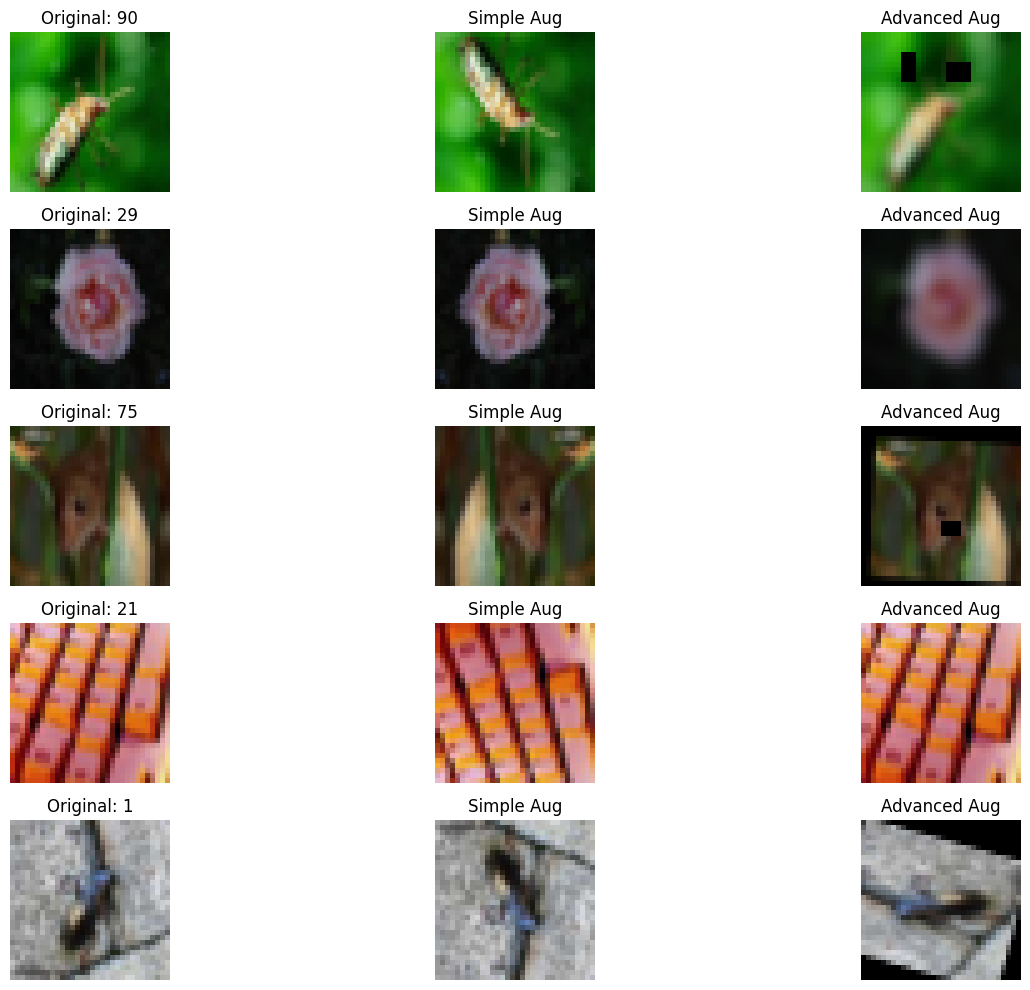

In [12]:
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(selected_classes):
    # Выбираем случайное изображение из класса
    class_dir = os.path.join(train_path, class_name)
    image_name = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, image_name)
    image = np.array(Image.open(image_path))

    # Применяем аугментации
    augmented_simple = simple_transform(image=image)["image"]
    augmented_advanced = advanced_transform(image=image)["image"]

    # Отрисовка
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(image)
    plt.title(f"Original: {class_name}")
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(augmented_simple)
    plt.title("Simple Aug")
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(augmented_advanced)
    plt.title("Advanced Aug")
    plt.axis('off')


plt.tight_layout()
plt.show()


### БЛОК 3: Обучение модели

In [13]:
# Сбор путей и меток
image_paths = []
labels = []
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(train_path, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_idx)

# Разделение на train/val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

In [14]:
advanced_transform_tl = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Resize(224, 224),  # Для ResNet
])

In [15]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]))
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        
        image = image / 255.0  # Нормализация [0, 1]
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # (C, H, W)
        return image, label

# Train/Val датасеты
train_dataset_simple = CustomDataset(train_paths, train_labels, simple_transform)
train_dataset_advanced = CustomDataset(train_paths, train_labels, advanced_transform)
train_dataset_tl = CustomDataset(train_paths, train_labels, advanced_transform_tl)  # Для TL

val_dataset = CustomDataset(val_paths, val_labels, A.Resize(32, 32))
val_dataset_tl = CustomDataset(val_paths, val_labels, A.Resize(224, 224))  # Для TL

# DataLoader
batch_size = 64
train_loader_simple = DataLoader(train_dataset_simple, batch_size=batch_size, shuffle=True)
train_loader_advanced = DataLoader(train_dataset_advanced, batch_size=batch_size, shuffle=True)
train_loader_tl = DataLoader(train_dataset_tl, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
val_loader_tl = DataLoader(val_dataset_tl, batch_size=batch_size, shuffle=False)

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_cnn = SimpleCNN(num_classes=num_classes)

In [17]:
model_tl = models.resnet18(pretrained=True)
model_tl.fc = nn.Linear(model_tl.fc.in_features, num_classes)  # Замена последнего слоя

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, scheduler, 
    epochs=50, patience=5, warmup_epochs=3
):
    model = model.to(device)
    best_val_acc = 0.0
    best_model = None
    early_stop_counter = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Warmup
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = optimizer.param_groups[0]['lr'] * (epoch + 1) / warmup_epochs

        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Scheduler
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Ранняя остановка
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            early_stop_counter = 0
            torch.save(model.state_dict(), f"best_model_epoch{epoch}.pt")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(
            f"Epoch {epoch+1}/{epochs}: "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}"
        )

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, train_accs, val_accs

In [19]:
# Для CNN с простой аугментацией
model_cnn = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

model_cnn_simple, cnn_simple_train_loss, cnn_simple_val_loss, cnn_simple_train_acc, cnn_simple_val_acc = train_model(
    model_cnn, train_loader_simple, val_loader, criterion, optimizer, scheduler
)

# Для CNN со сложной аугментацией
model_cnn_advanced, cnn_adv_train_loss, cnn_adv_val_loss, cnn_adv_train_acc, cnn_adv_val_acc = train_model(
    model_cnn, train_loader_advanced, val_loader, criterion, optimizer, scheduler
)

# Для Transfer Learning (ResNet18)
model_tl = model_tl.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tl.parameters(), lr=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

model_tl, tl_train_loss, tl_val_loss, tl_train_acc, tl_val_acc = train_model(
    model_tl, train_loader_tl, val_loader_tl, criterion, optimizer, scheduler
)

100%|██████████| 119/119 [00:14<00:00,  8.06it/s]


Epoch 1/50: Train Loss: 4.4915, Val Loss: 4.3056, Train Acc: 0.0218, Val Acc: 0.0405


100%|██████████| 119/119 [00:07<00:00, 15.43it/s]


Epoch 2/50: Train Loss: 4.1951, Val Loss: 4.0890, Train Acc: 0.0605, Val Acc: 0.0789


100%|██████████| 119/119 [00:07<00:00, 15.02it/s]


Epoch 3/50: Train Loss: 4.0458, Val Loss: 3.9754, Train Acc: 0.0789, Val Acc: 0.0999


100%|██████████| 119/119 [00:07<00:00, 15.00it/s]


Epoch 4/50: Train Loss: 3.9148, Val Loss: 3.8257, Train Acc: 0.1006, Val Acc: 0.1204


100%|██████████| 119/119 [00:08<00:00, 14.38it/s]


Epoch 5/50: Train Loss: 3.7632, Val Loss: 3.7053, Train Acc: 0.1253, Val Acc: 0.1451


100%|██████████| 119/119 [00:07<00:00, 14.95it/s]


Epoch 6/50: Train Loss: 3.6524, Val Loss: 3.5784, Train Acc: 0.1425, Val Acc: 0.1567


100%|██████████| 119/119 [00:07<00:00, 16.15it/s]


Epoch 7/50: Train Loss: 3.5423, Val Loss: 3.5712, Train Acc: 0.1682, Val Acc: 0.1593


100%|██████████| 119/119 [00:07<00:00, 16.87it/s]


Epoch 8/50: Train Loss: 3.4504, Val Loss: 3.4647, Train Acc: 0.1819, Val Acc: 0.1809


100%|██████████| 119/119 [00:07<00:00, 15.34it/s]


Epoch 9/50: Train Loss: 3.3800, Val Loss: 3.4303, Train Acc: 0.1972, Val Acc: 0.1782


100%|██████████| 119/119 [00:07<00:00, 15.77it/s]


Epoch 10/50: Train Loss: 3.3156, Val Loss: 3.3972, Train Acc: 0.2064, Val Acc: 0.1772


100%|██████████| 119/119 [00:08<00:00, 14.01it/s]


Epoch 11/50: Train Loss: 3.2549, Val Loss: 3.3598, Train Acc: 0.2107, Val Acc: 0.1961


100%|██████████| 119/119 [00:07<00:00, 14.98it/s]


Epoch 12/50: Train Loss: 3.1944, Val Loss: 3.3140, Train Acc: 0.2271, Val Acc: 0.1935


100%|██████████| 119/119 [00:07<00:00, 14.89it/s]


Epoch 13/50: Train Loss: 3.1279, Val Loss: 3.3059, Train Acc: 0.2401, Val Acc: 0.2161


100%|██████████| 119/119 [00:07<00:00, 16.21it/s]


Epoch 14/50: Train Loss: 3.0792, Val Loss: 3.2639, Train Acc: 0.2453, Val Acc: 0.2177


100%|██████████| 119/119 [00:07<00:00, 15.36it/s]


Epoch 15/50: Train Loss: 3.0368, Val Loss: 3.2621, Train Acc: 0.2513, Val Acc: 0.2182


100%|██████████| 119/119 [00:07<00:00, 15.77it/s]


Epoch 16/50: Train Loss: 2.9723, Val Loss: 3.2478, Train Acc: 0.2641, Val Acc: 0.2208


100%|██████████| 119/119 [00:08<00:00, 13.84it/s]


Epoch 17/50: Train Loss: 2.9289, Val Loss: 3.2651, Train Acc: 0.2710, Val Acc: 0.2198


100%|██████████| 119/119 [00:07<00:00, 15.14it/s]


Epoch 18/50: Train Loss: 2.8839, Val Loss: 3.2098, Train Acc: 0.2809, Val Acc: 0.2392


100%|██████████| 119/119 [00:08<00:00, 14.87it/s]


Epoch 19/50: Train Loss: 2.8358, Val Loss: 3.2282, Train Acc: 0.2897, Val Acc: 0.2303


100%|██████████| 119/119 [00:07<00:00, 16.14it/s]


Epoch 20/50: Train Loss: 2.7989, Val Loss: 3.1780, Train Acc: 0.2917, Val Acc: 0.2513


100%|██████████| 119/119 [00:07<00:00, 15.55it/s]


Epoch 21/50: Train Loss: 2.7511, Val Loss: 3.1881, Train Acc: 0.3065, Val Acc: 0.2482


100%|██████████| 119/119 [00:08<00:00, 14.56it/s]


Epoch 22/50: Train Loss: 2.7043, Val Loss: 3.1982, Train Acc: 0.3139, Val Acc: 0.2513


100%|██████████| 119/119 [00:08<00:00, 14.08it/s]


Epoch 23/50: Train Loss: 2.6784, Val Loss: 3.2530, Train Acc: 0.3203, Val Acc: 0.2350


100%|██████████| 119/119 [00:08<00:00, 14.06it/s]


Epoch 24/50: Train Loss: 2.6440, Val Loss: 3.2176, Train Acc: 0.3268, Val Acc: 0.2455


100%|██████████| 119/119 [00:08<00:00, 14.21it/s]


Epoch 25/50: Train Loss: 2.4973, Val Loss: 3.1332, Train Acc: 0.3607, Val Acc: 0.2645


100%|██████████| 119/119 [00:07<00:00, 15.63it/s]


Epoch 26/50: Train Loss: 2.4606, Val Loss: 3.1387, Train Acc: 0.3695, Val Acc: 0.2618


100%|██████████| 119/119 [00:08<00:00, 14.00it/s]


Epoch 27/50: Train Loss: 2.4489, Val Loss: 3.1472, Train Acc: 0.3730, Val Acc: 0.2660


100%|██████████| 119/119 [00:07<00:00, 15.43it/s]


Epoch 28/50: Train Loss: 2.4414, Val Loss: 3.1522, Train Acc: 0.3736, Val Acc: 0.2655


100%|██████████| 119/119 [00:08<00:00, 13.81it/s]


Epoch 29/50: Train Loss: 2.4363, Val Loss: 3.1545, Train Acc: 0.3738, Val Acc: 0.2645


100%|██████████| 119/119 [00:08<00:00, 14.71it/s]


Epoch 30/50: Train Loss: 2.4119, Val Loss: 3.1501, Train Acc: 0.3772, Val Acc: 0.2692


100%|██████████| 119/119 [00:08<00:00, 14.33it/s]


Epoch 31/50: Train Loss: 2.4134, Val Loss: 3.1502, Train Acc: 0.3780, Val Acc: 0.2692


100%|██████████| 119/119 [00:07<00:00, 15.69it/s]


Epoch 32/50: Train Loss: 2.4048, Val Loss: 3.1510, Train Acc: 0.3814, Val Acc: 0.2681


100%|██████████| 119/119 [00:07<00:00, 14.93it/s]


Epoch 33/50: Train Loss: 2.4092, Val Loss: 3.1515, Train Acc: 0.3784, Val Acc: 0.2692


100%|██████████| 119/119 [00:07<00:00, 15.02it/s]


Epoch 34/50: Train Loss: 2.4056, Val Loss: 3.1514, Train Acc: 0.3800, Val Acc: 0.2692


100%|██████████| 119/119 [00:08<00:00, 14.48it/s]


Early stopping at epoch 34


100%|██████████| 119/119 [00:10<00:00, 11.28it/s]


Epoch 1/50: Train Loss: 3.7082, Val Loss: 3.1513, Train Acc: 0.1832, Val Acc: 0.2713


100%|██████████| 119/119 [00:10<00:00, 11.77it/s]


Epoch 2/50: Train Loss: 3.7224, Val Loss: 3.1515, Train Acc: 0.1757, Val Acc: 0.2702


100%|██████████| 119/119 [00:09<00:00, 11.95it/s]


Epoch 3/50: Train Loss: 3.7380, Val Loss: 3.1516, Train Acc: 0.1811, Val Acc: 0.2702


100%|██████████| 119/119 [00:10<00:00, 11.50it/s]


Epoch 4/50: Train Loss: 3.7411, Val Loss: 3.1516, Train Acc: 0.1778, Val Acc: 0.2697


100%|██████████| 119/119 [00:10<00:00, 11.03it/s]


Epoch 5/50: Train Loss: 3.7303, Val Loss: 3.1516, Train Acc: 0.1831, Val Acc: 0.2697


100%|██████████| 119/119 [00:10<00:00, 11.02it/s]


Early stopping at epoch 5


100%|██████████| 119/119 [00:28<00:00,  4.25it/s]


Epoch 1/50: Train Loss: 4.3527, Val Loss: 3.7391, Train Acc: 0.0708, Val Acc: 0.1972


100%|██████████| 119/119 [00:28<00:00,  4.24it/s]


Epoch 2/50: Train Loss: 3.7446, Val Loss: 3.2642, Train Acc: 0.1856, Val Acc: 0.3002


100%|██████████| 119/119 [00:27<00:00,  4.32it/s]


Epoch 3/50: Train Loss: 3.4242, Val Loss: 2.9348, Train Acc: 0.2445, Val Acc: 0.3517


100%|██████████| 119/119 [00:27<00:00,  4.27it/s]


Epoch 4/50: Train Loss: 3.1743, Val Loss: 2.6978, Train Acc: 0.2919, Val Acc: 0.3885


100%|██████████| 119/119 [00:27<00:00,  4.33it/s]


Epoch 5/50: Train Loss: 2.9917, Val Loss: 2.5488, Train Acc: 0.3206, Val Acc: 0.4190


100%|██████████| 119/119 [00:28<00:00,  4.25it/s]


Epoch 6/50: Train Loss: 2.8723, Val Loss: 2.4312, Train Acc: 0.3479, Val Acc: 0.4401


100%|██████████| 119/119 [00:27<00:00,  4.35it/s]


Epoch 7/50: Train Loss: 2.7944, Val Loss: 2.3612, Train Acc: 0.3650, Val Acc: 0.4532


100%|██████████| 119/119 [00:28<00:00,  4.24it/s]


Epoch 8/50: Train Loss: 2.7280, Val Loss: 2.3300, Train Acc: 0.3796, Val Acc: 0.4621


100%|██████████| 119/119 [00:27<00:00,  4.33it/s]


Epoch 9/50: Train Loss: 2.7033, Val Loss: 2.3091, Train Acc: 0.3808, Val Acc: 0.4627


100%|██████████| 119/119 [00:27<00:00,  4.31it/s]


Epoch 10/50: Train Loss: 2.6865, Val Loss: 2.2974, Train Acc: 0.3945, Val Acc: 0.4600


100%|██████████| 119/119 [00:27<00:00,  4.37it/s]


Epoch 11/50: Train Loss: 2.6985, Val Loss: 2.3015, Train Acc: 0.3853, Val Acc: 0.4642


100%|██████████| 119/119 [00:26<00:00,  4.44it/s]


Epoch 12/50: Train Loss: 2.6769, Val Loss: 2.2803, Train Acc: 0.3952, Val Acc: 0.4648


100%|██████████| 119/119 [00:27<00:00,  4.37it/s]


Epoch 13/50: Train Loss: 2.6422, Val Loss: 2.2112, Train Acc: 0.4013, Val Acc: 0.4821


100%|██████████| 119/119 [00:27<00:00,  4.37it/s]


Epoch 14/50: Train Loss: 2.5642, Val Loss: 2.0943, Train Acc: 0.4044, Val Acc: 0.5026


100%|██████████| 119/119 [00:28<00:00,  4.23it/s]


Epoch 15/50: Train Loss: 2.4414, Val Loss: 1.9461, Train Acc: 0.4176, Val Acc: 0.5263


100%|██████████| 119/119 [00:27<00:00,  4.38it/s]


Epoch 16/50: Train Loss: 2.3094, Val Loss: 1.8299, Train Acc: 0.4473, Val Acc: 0.5358


100%|██████████| 119/119 [00:27<00:00,  4.35it/s]


Epoch 17/50: Train Loss: 2.1558, Val Loss: 1.6592, Train Acc: 0.4813, Val Acc: 0.5705


100%|██████████| 119/119 [00:27<00:00,  4.32it/s]


Epoch 18/50: Train Loss: 1.9922, Val Loss: 1.6029, Train Acc: 0.5030, Val Acc: 0.5804


100%|██████████| 119/119 [00:27<00:00,  4.26it/s]


Epoch 19/50: Train Loss: 1.8674, Val Loss: 1.5408, Train Acc: 0.5250, Val Acc: 0.5988


100%|██████████| 119/119 [00:27<00:00,  4.30it/s]


Epoch 20/50: Train Loss: 1.7434, Val Loss: 1.4807, Train Acc: 0.5492, Val Acc: 0.5836


100%|██████████| 119/119 [00:27<00:00,  4.26it/s]


Epoch 21/50: Train Loss: 1.6481, Val Loss: 1.4556, Train Acc: 0.5686, Val Acc: 0.6015


100%|██████████| 119/119 [00:28<00:00,  4.24it/s]


Epoch 22/50: Train Loss: 1.5494, Val Loss: 1.4129, Train Acc: 0.5924, Val Acc: 0.6109


100%|██████████| 119/119 [00:27<00:00,  4.29it/s]


Epoch 23/50: Train Loss: 1.4579, Val Loss: 1.3264, Train Acc: 0.6200, Val Acc: 0.6409


100%|██████████| 119/119 [00:27<00:00,  4.33it/s]


Epoch 24/50: Train Loss: 1.3451, Val Loss: 1.3051, Train Acc: 0.6483, Val Acc: 0.6335


100%|██████████| 119/119 [00:27<00:00,  4.27it/s]


Epoch 25/50: Train Loss: 1.2842, Val Loss: 1.2570, Train Acc: 0.6604, Val Acc: 0.6530


100%|██████████| 119/119 [00:27<00:00,  4.36it/s]


Epoch 26/50: Train Loss: 1.2023, Val Loss: 1.2441, Train Acc: 0.6895, Val Acc: 0.6514


100%|██████████| 119/119 [00:27<00:00,  4.34it/s]


Epoch 27/50: Train Loss: 1.1037, Val Loss: 1.2190, Train Acc: 0.7161, Val Acc: 0.6535


100%|██████████| 119/119 [00:27<00:00,  4.32it/s]


Epoch 28/50: Train Loss: 1.0675, Val Loss: 1.1922, Train Acc: 0.7221, Val Acc: 0.6661


100%|██████████| 119/119 [00:27<00:00,  4.28it/s]


Epoch 29/50: Train Loss: 1.0234, Val Loss: 1.1907, Train Acc: 0.7388, Val Acc: 0.6630


100%|██████████| 119/119 [00:27<00:00,  4.27it/s]


Epoch 30/50: Train Loss: 1.0125, Val Loss: 1.1907, Train Acc: 0.7426, Val Acc: 0.6609


100%|██████████| 119/119 [00:27<00:00,  4.25it/s]


Epoch 31/50: Train Loss: 0.9991, Val Loss: 1.1881, Train Acc: 0.7432, Val Acc: 0.6598


100%|██████████| 119/119 [00:27<00:00,  4.26it/s]


Epoch 32/50: Train Loss: 1.0177, Val Loss: 1.1863, Train Acc: 0.7379, Val Acc: 0.6640


100%|██████████| 119/119 [00:27<00:00,  4.30it/s]


Early stopping at epoch 32


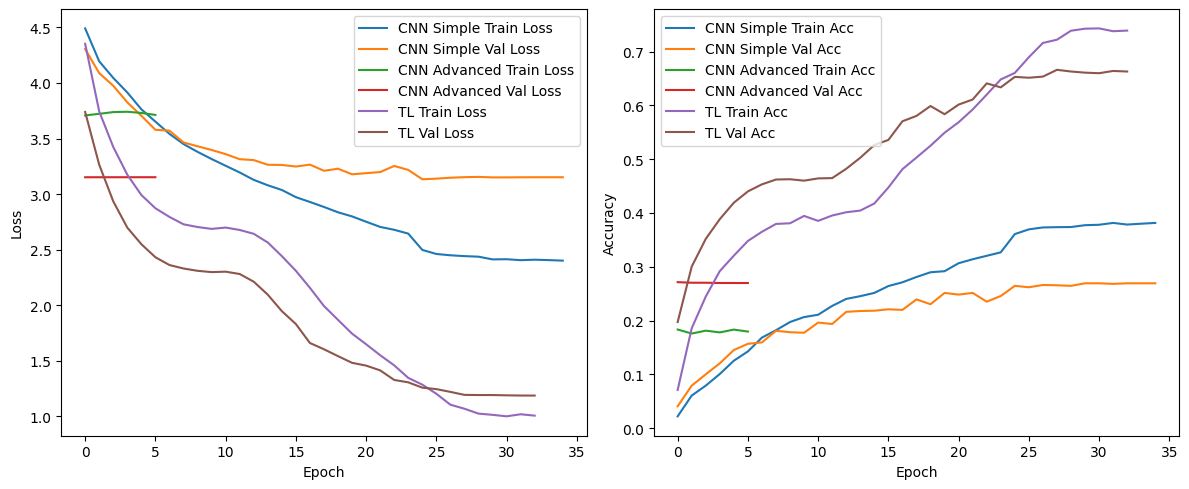

In [20]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_simple_train_loss, label='CNN Simple Train Loss')
plt.plot(cnn_simple_val_loss, label='CNN Simple Val Loss')
plt.plot(cnn_adv_train_loss, label='CNN Advanced Train Loss')
plt.plot(cnn_adv_val_loss, label='CNN Advanced Val Loss')
plt.plot(tl_train_loss, label='TL Train Loss')
plt.plot(tl_val_loss, label='TL Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_simple_train_acc, label='CNN Simple Train Acc')
plt.plot(cnn_simple_val_acc, label='CNN Simple Val Acc')
plt.plot(cnn_adv_train_acc, label='CNN Advanced Train Acc')
plt.plot(cnn_adv_val_acc, label='CNN Advanced Val Acc')
plt.plot(tl_train_acc, label='TL Train Acc')
plt.plot(tl_val_acc, label='TL Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Используем тот же transform, что и для валидации!
test_transform = A.Compose([
    #A.Resize(32, 32),  # Для CNN
    A.Resize(224, 224),  # Для ResNet
])

class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]))
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        image = image / 255.0  # Нормализация как в трейне
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        return image

# Собираем пути к тестовым изображениям в правильном порядке
test_images = sorted(
    [os.path.join(test_path, img) for img in os.listdir(test_path)],
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])  # Сортировка по числу в имени файла
)

# Создаем датасет и DataLoader
test_dataset = TestDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Функция предсказания
def predict(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in loader:  # Теперь нет меток!
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Получаем предсказания
preds = predict(model_tl, test_loader)  # Используйте нужную модель

pred_classes = [class_names[pred] for pred in preds]

# Создаем df с id и target
submission_df = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(img))[0] for img in test_images],
    'target': pred_classes
})


In [23]:
print(submission_df.head(15))

    id target
0    0     71
1    1     62
2    2     39
3    3     62
4    4     66
5    5     74
6    6     12
7    7     38
8    8      3
9    9     52
10  10     85
11  11     82
12  12     42
13  13     80
14  14     10


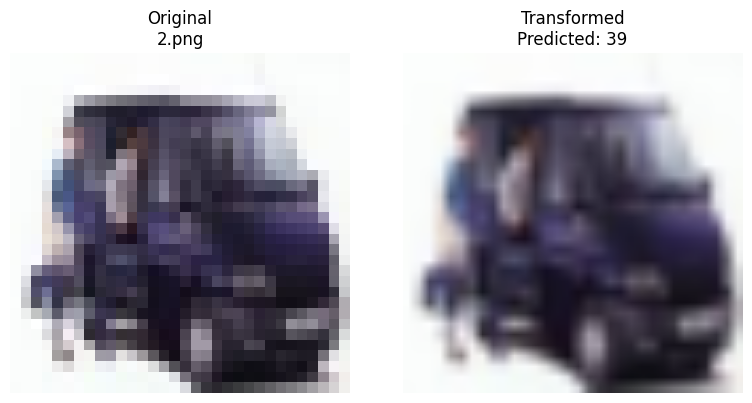

In [24]:
model_tl.eval()
img_path = test_images[2]  # Первое тестовое изображение
img_pil = Image.open(img_path)  # Загрузка в PIL
img_np = np.array(img_pil)  # Конвертация в numpy

# Предобработка для модели
img_transformed = test_transform(image=img_np)["image"]  # Трансформации
img_tensor = torch.from_numpy(img_transformed).unsqueeze(0).permute(0, 3, 1, 2).float() / 255.0

# Предсказание
with torch.no_grad():
    pred = model_tl(img_tensor.to(device)).argmax().item()
pred_class = class_names[pred]  # Название класса

# Визуализация
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np) 
plt.title(f"Original\n{os.path.basename(img_path)}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_transformed)
plt.title(f"Transformed\nPredicted: {pred_class}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

### БЛОК 4: Генератор

In [27]:
img_size_1 = 32
channels = 3
num_classes = 100
latent_dim = 100
batch_size = 32
epochs = 10
sample_interval = 100


#### 1. Загрузка и подготовка данных для генератора

In [14]:
def load_images(class_names, img_size=(img_size_1, img_size_1)):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(train_path, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in image_files[:100]:  # Ограничим количество для демонстрации
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e: # Обработка исключений: если изображение битое или не читается
                print(f"Error loading {img_path}: {e}")
                continue
                
    images = np.array(images) #преобразование списков в массивы
    labels = np.array(labels)
    
    images = (images.astype(np.float32) - 127.5) / 127.5 # Нормализация изображений [-1, 1 для GAN
    
    return images, labels

# Загрузка данных
class_names = os.listdir(train_path)
X_train, y_train = load_images(class_names)
print(f"Загружено {X_train.shape[0]} изображений размером {X_train.shape[1:]}")

Загружено 8209 изображений размером (32, 32, 3)


#### 2. Создание cGAN

In [26]:
# Генератор
def build_generator():
    # Условный вход (метка класса)
    label_input = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(label_input)
    li = layers.Dense(4 * 4 * 128)(li)  # такой же как у шума
    li = layers.Reshape((4, 4, 128))(li)

    
    # Шумовой вход
    noise_input = layers.Input(shape=(latent_dim,))
    noise = layers.Dense(4 * 4 * 128)(noise_input)
    noise = layers.Reshape((4, 4, 128))(noise)
    
    # Объединение шума и метки
    merged = layers.Concatenate()([noise, li]) # (4, 4, 256)
    
    # Блоки генератора
    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merged)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    
    x = layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    
    x = layers.Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    
    # Выходной слой
    output = layers.Conv2D(channels, (3,3), activation='tanh', padding='same')(x)
    
    return models.Model([noise_input, label_input], output)

# Дискриминатор
def build_discriminator():
    # Вход изображения
    img_input = layers.Input(shape=(img_size_1, img_size_1, channels))

    x = layers.Conv2D(32, (3,3), strides=(2,2), padding='same')(img_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)

    x = layers.Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)

    # Вход метки
    label_input = layers.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(label_input)
    li = layers.Dense(x.shape[-1])(li)  # динамическая подгонка
    li = layers.LeakyReLU(0.2)(li)
    li = layers.Flatten()(li)

    merged = layers.Concatenate()([x, li])

    validity = layers.Dense(1, activation='sigmoid')(merged)

    return models.Model([img_input, label_input], validity)


# Создание и компиляция моделей
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy']) #Компилируем дискриминатор 

generator = build_generator() #Создаем наш генератор

# Замораживаем веса дискриминатора для обучения генератора
discriminator.trainable = False

# Комбинированная модель
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([noise, label])
valid = discriminator([img, label])

cgan = models.Model([noise, label], valid) 
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)

#### 3. Обучение cGAN

In [28]:
def train_cgan(epochs, batch_size, sample_interval):
    # Метки для реальных и фейковых изображений
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # ---------------------
        #  Обучение дискриминатора
        # ---------------------
        
        # Выбор случайного батча реальных изображений
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        # Генерация фейковых изображений
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels])
        
        # Обучение дискриминатора
        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Обучение генератора
        # ---------------------
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size)
        
        # Мы хотим, чтобы генератор обманывал дискриминатор
        g_loss = cgan.train_on_batch([noise, sampled_labels], valid)
        
        # Прогресс обучения
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
        
        # Сохранение сгенерированных изображений
        if epoch % sample_interval == 0:
            sample_images(epoch)

def sample_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, r * c)
    
    gen_imgs = generator.predict([noise, sampled_labels])
    
    # Денормализация изображений [0,1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].set_title(f"Class: {sampled_labels[cnt]}")
            axs[i,j].axis('off')
            cnt += 1
    plt.savefig(f"generated_{epoch}.png")
    plt.close()

# Запуск обучения
train_cgan(epochs, batch_size, sample_interval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
0 [D loss: 0.6843552589416504 | D accuracy: 70.3125] [G loss: [array(0.68773854, dtype=float32), array(0.68773854, dtype=float32), array(0.59375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1 [D loss: 0.686484694480896 | D accuracy: 63.28125] [G loss: [array(0.687796, dtype=float32), array(0.687796, dtype=float32), array(0.578125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2 [D loss: 0.6871061325073242 | D accuracy: 59.11458730697632] [G loss: [array(0.6879091, dtype=float32), array(0.6879091, dtype=float32), array(0.5572917, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3 [D loss: 0.6871364116668701 | D accuracy: 57.05915093421936] [G loss: [array(0.6877845, dtype=float32), array(0.6877845, dtype=float32), array(0.54296875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4 [D loss: 0.6878303289413452 | D accuracy: 55.20833730697632] [G loss: [array(0.68839437, dtype=flo

#### 4. Генерация новых изображений

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


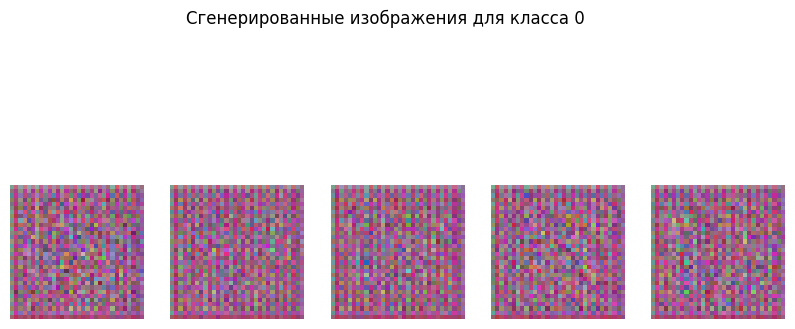

In [30]:
def generate_class_images(class_idx, num_images, generator):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    labels = np.full((num_images,), class_idx)
    gen_imgs = generator.predict([noise, labels]) #генерация изображений
    
    # Денормализация и преобразование в uint8
    gen_imgs = 0.5 * gen_imgs + 0.5
    gen_imgs = (gen_imgs * 255).astype(np.uint8)
    
    return gen_imgs

# Пример генерации 10 изображений для класса 0
class_idx = 0
generated_images = generate_class_images(class_idx, 10, generator)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.suptitle(f"Сгенерированные изображения для класса {class_idx}")
plt.show()